In [20]:
import pickle
import pandas as pd
import sys
import tweepy
from colour import Color
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from numpy import median
import emoji
import time
from datetime import datetime
from collections import Counter, defaultdict
import operator
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
%matplotlib inline

# Part 1 - Read in Twitter data

## Define functions to help scrape twitter

In [4]:
def loadkeys(filename):
    """"
    load twitter api keys/tokens from CSV file with form
    consumer_key, consumer_secret, access_token, access_token_secret
    """
    with open(filename) as f:
        items = f.readline().strip().split(',')
        return items
    
    
def authenticate(twitter_auth_filename):
    """
    Given a file name containing the Twitter keys and tokens,
    create and return a tweepy API object.
    """

    consumer_key, consumer_secret, access_token, access_token_secret = loadkeys(twitter_auth_filename)
    print(consumer_key)
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth)
    return api


def fetch_tweets(api, name):
    """
    Given a tweepy API object and the screen name of the Twitter user,
    create a list of tweets where each tweet is a dictionary with the
    following keys:
       id: tweet ID
       created: tweet creation date
       retweeted: number of retweets
       text: text of the tweet
       hashtags: list of hashtags mentioned in the tweet
       urls: list of URLs mentioned in the tweet
       mentions: list of screen names mentioned in the tweet
       score: the "compound" polarity score from vader's polarity_scores()
    Return a dictionary containing keys-value pairs:
       user: user's screen name
       count: number of tweets
       tweets: list of tweets, each tweet is a dictionary
    For efficiency, create a single Vader SentimentIntensityAnalyzer()
    per call to this function, not per tweet.
    """
    analyzer = SentimentIntensityAnalyzer()

    tweets = []
    for status in tweepy.Cursor(api.user_timeline, id=name).items(125):
        this_tweet = {}

        this_tweet["text"] = status.text
        this_tweet["id"] = status.id
        this_tweet["created"] = status.created_at
        this_tweet["retweeted"] = status.retweet_count
        this_tweet["score"] = analyzer.polarity_scores(status.text)['compound']

        hashtags = []
        urls = []
        mentions = []

        for word in status.text.split(" "):
            if word.startswith("#"):
                hashtags.append(word)

            if word.startswith("@"):
                mentions.append(word)

            if word.startswith("http"):
                urls.append(word)

        this_tweet["hashtags"] = hashtags
        this_tweet["mentions"] =mentions
        this_tweet["urls"] = urls

        tweets.append(this_tweet)

    return tweets


def fetch_following(api,name):
    """
    Given a tweepy API object and the screen name of the Twitter user,
    return a a list of dictionaries containing the followed user info
    with keys-value pairs:
       name: real name
       screen_name: Twitter screen name
       followers: number of followers
       created: created date (no time info)
       image: the URL of the profile's image
    To collect data: get a list of "friends IDs" then get
    the list of users for each of those.
    """

    twitter_following = []
    user_ = tweepy.Cursor(api.friends, id=name).items()
    for user in user_:

        following = {}
        following["image"] = user.profile_image_url_https
        following["followers"] = user.followers_count
        following["name"] = user.name
        following["screen_name"] = user.screen_name
        following["created"] = user.created_at.date()
        twitter_following.append(following)

    return twitter_following


def add_color(tweets):
    """
    Given a list of tweets, one dictionary per tweet, add
    a "color" key to each tweets dictionary with a value
    containing a color graded from red to green. Pure red
    would be for -1.0 sentiment score and pure green would be for
    sentiment score 1.0.
    Use colour.Color to get 100 color values in the range
    from red to green. Then convert the sentiment score from -1..1
    to an index from 0..100. That index gives you the color increment
    from the 100 gradients.
    This function modifies the dictionary of each tweet. It lives in
    the server script because it has to do with display not collecting
    tweets.
    """
    colors = list(Color("red").range_to(Color("green"), 100))
    
    for t in tweets:
        score = int(((t['score']+1)*100)/2)
        t["color"] = colors[score]
    return tweets

def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

### Step 1: authenticate twitter api

In [ ]:
# authenticate twitter api
twitter_auth_filename = '/Users/saramahar/Documents/USF/passwords/twitter_pass.csv'
api = authenticate(twitter_auth_filename)

### Step 2: Get top 200 most followed Twitter users

In [ ]:
top500 = pd.read_csv('top500.csv')

In [ ]:
top_df = pd.DataFrame(columns = ['name', 'followers', 'rank'])

In [ ]:
this_dict = {}
for i,row in enumerate(top500.iterrows()):
    val = row[1].item()
    if i % 6 == 1:
        this_dict['name'] = val
    if i % 6 == 3:
        this_dict['followers'] = val
    if i %6 == 5:
        this_dict['rank'] = str(int(val) -1)
        
    if i % 6 ==5:
        top_df = top_df.append(this_dict, ignore_index = True)
        this_dict = {}

### Step 3: Get the tweets from top 200 users

In [ ]:
def get_tweets_dict(username_df, api, pickle_filename):
    """ Given a dataframe with top Twitter user handles, number of followers and ranking,
        make a dictionary with the key as their username, and with their emojis, number
        of retweets, the sentiment of the tweet, number of followers, and the user ranking.
        This returns this tweet dictionary and also writes out to a pickle file.
    """
    tweet_dict = {}
    for row in top200.iterrows():
        name = row[1]['name']
        followers = row[1]['followers']
        rank = row[1]['rank']

        print(name)
        print(str(datetime.now()))

        tweets = fetch_tweets(api, name)

        tweets = add_color(tweets)

        tweet_score = [t["score"] for t in tweets]
        retweets = [t['retweeted'] for t in tweets]
        emojis = [extract_emojis(t) for t in tweet_text]
        tweet_dict[name] = {'emojis': emojis,'retweets':retweets,'score': tweet_score,
                            'followers':followers,'rank':rank}
        time.sleep(900)
    with open(pickle_filename, 'wb') as handle:
        pickle.dump(tweet_dict2, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
        
    return(tweet_dict)

In [ ]:
top200 = top_df[:200]
pickle_filename = 'tweets.pickle'
tweet_dict = get_tweets_dict(top200, api, pickle_filename)

### Step 4: Read in pickle file

In [129]:
tweets

{'katyperry': {'emojis': ['üëÅ‚ù§',
   '',
   '',
   '‚ùóüéÇüéà',
   '',
   '',
   'ü§ùüåéüí™üåçüôåüåè‚ù§üëµ',
   '',
   'üåà‚ù§\U0001f9e1üíõüíöüíôüíúüåà',
   '‚ô•',
   'üå∏üìπ',
   '',
   '',
   '',
   '‚ú®üëèüç¨',
   '',
   'üëëüëë',
   'üò≠‚ù§',
   '‚ú®',
   '‚Äº',
   'üò©‚ùó‚ùóüôè',
   'üòà',
   'üò©',
   '',
   '',
   'üî•',
   '',
   'üò©',
   'üåÖüî•üåÖ',
   'üò±',
   '‚Äºüò©',
   '‚ú®‚ú®üò±',
   '',
   '',
   'üåº',
   '‚òùüíÅ',
   'ü§†',
   'üòùü§¶‚ôÇ',
   'üåéüè†',
   '',
   'ü¶ÅüåÆüò±üîú',
   '',
   '',
   '‚ù§üéü',
   'üëëüëëüòáüòá‚Äº',
   '',
   '',
   '',
   '',
   '',
   '',
   '',
   'üëèüëè‚ùóüí•üì∫‚úÖ',
   'üéü',
   '‚ù§',
   'üî•‚òë‚òëüé§üèÜ',
   'ü§óüëë‚ô•',
   '‚ô•',
   '‚ú®‚ú®üì∏',
   '‚ô•',
   '‚ô•',
   '‚ô•',
   '',
   '‚úåüéü',
   '',
   'üòù',
   '‚ô•',
   'üòùüê¥',
   'üì∫‚úÖ',
   'üö®',
   '‚úåüö®üîà',
   'üíã',
   'ü§∑‚ôÇ',
   '‚ú®',
   '‚ú®üòëüò¥üòò',
   '‚úÖ‚úÖ‚úÖ',
   '‚ùÑ',
   ''

In [5]:
tweets_pick = open('all_tweets.pickle', 'rb')
tweets = pickle.load(tweets_pick)
tweets_pick.close()

## Question: what are the most popular emojis? And what is the sentiment around those emojis?

## Look at the most frequent emojis

In [6]:
def frequent_emojis(tweets, total = True):
    tweet_count = {}
    for key in tweets:
        tweet_count[key] = Counter([y for x in tweets[key]['emojis'] for y in x])
    all_emojis = defaultdict(int)
    for val in tweet_count:
        for em in tweet_count[val]:
            if total:
                all_emojis[em]  = all_emojis[em] + tweet_count[val][em]
            else:
                all_emojis[em]  = all_emojis[em] + 1

    sorted_emojis = sorted(all_emojis.items(), key=operator.itemgetter(1), reverse=True)
    return(sorted_emojis)

In [8]:
# raw number of mentions 
raw_freq = frequent_emojis(tweets)
raw_freq

[('‚ù§', 804),
 ('üî•', 630),
 ('üôè', 513),
 ('üëè', 488),
 ('‚öΩ', 429),
 ('üôå', 355),
 ('üòÇ', 354),
 ('üí™', 339),
 ('üòç', 271),
 ('üèÜ', 258),
 ('üòò', 210),
 ('‚ú®', 186),
 ('üî¥', 165),
 ('üëç', 130),
 ('üîµ', 128),
 ('üòä', 125),
 ('ü§£', 124),
 ('üé∂', 124),
 ('üëå', 122),
 ('üëÄ', 115),
 ('üëá', 115),
 ('üòé', 112),
 ('üå∏', 109),
 ('üíï', 108),
 ('üéâ', 106),
 ('üí•', 104),
 ('‚ô•', 102),
 ('üòâ', 99),
 ('ü§î', 99),
 ('ü§ô', 97),
 ('üíô', 91),
 ('üíã', 81),
 ('‚ö°', 75),
 ('üòÄ', 74),
 ('üëâ', 74),
 ('‚úÖ', 72),
 ('üò≠', 71),
 ('‚û°', 71),
 ('‚ôÄ', 68),
 ('üëä', 65),
 ('üö®', 64),
 ('‚ôÇ', 57),
 ('üåà', 56),
 ('üé≤', 56),
 ('üåü', 54),
 ('üíñ', 53),
 ('‚úå', 52),
 ('üíõ', 51),
 ('üíú', 49),
 ('üöÄ', 49),
 ('üòÅ', 48),
 ('üåç', 47),
 ('üëë', 47),
 ('üòù', 47),
 ('ü§ó', 47),
 ('üòú', 47),
 ('üíØ', 47),
 ('üíÉ', 46),
 ('üò±', 45),
 ('üòÉ', 44),
 ('üé•', 42),
 ('‚≠ê', 41),
 ('üì∏', 40),
 ('üò©', 39),
 ('‚úà', 37),
 ('üëã', 

In [116]:
[x[0] for x in raw_freq[:25]]

['‚ù§',
 'üî•',
 'üôè',
 'üëè',
 '‚öΩ',
 'üôå',
 'üòÇ',
 'üí™',
 'üòç',
 'üèÜ',
 'üòò',
 '‚ú®',
 'üî¥',
 'üëç',
 'üîµ',
 'üòä',
 'ü§£',
 'üé∂',
 'üëå',
 'üëÄ',
 'üëá',
 'üòé',
 'üå∏',
 'üíï',
 'üéâ']

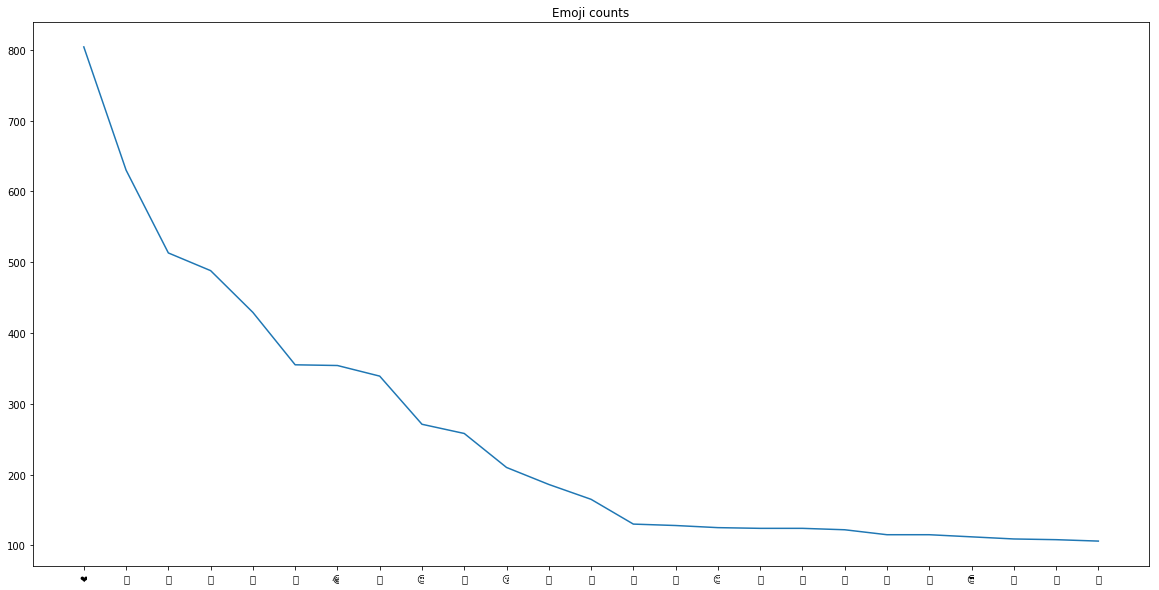

In [112]:
emojiis = [k[0] for k in raw_freq[:25]]
counts = [k[1] for k in raw_freq[:25]]

plt.figure(figsize = (20,10))
plt.plot(emojiis, counts)
plt.title('Emoji counts');

In [15]:
# number of tweets mentioned in 
tweets_mentioned = frequent_emojis(tweets, total = False)
tweets_mentioned

[('‚ù§', 88),
 ('üôè', 70),
 ('üòÇ', 70),
 ('üôå', 69),
 ('üëè', 67),
 ('üî•', 62),
 ('üòç', 58),
 ('üí™', 55),
 ('üëÄ', 45),
 ('üéâ', 45),
 ('üòé', 43),
 ('üòò', 39),
 ('üëç', 39),
 ('‚ú®', 38),
 ('üé∂', 38),
 ('üòâ', 37),
 ('üòä', 35),
 ('‚öΩ', 34),
 ('ü§î', 34),
 ('üèÜ', 33),
 ('üëå', 33),
 ('üí•', 29),
 ('üíï', 29),
 ('üíô', 28),
 ('üòú', 28),
 ('üëá', 28),
 ('‚û°', 27),
 ('üò±', 26),
 ('üíÉ', 26),
 ('üòÅ', 26),
 ('üëâ', 25),
 ('üëä', 25),
 ('üò≠', 24),
 ('ü§£', 24),
 ('‚ôÄ', 24),
 ('üíØ', 24),
 ('‚ôÇ', 23),
 ('ü§ó', 23),
 ('‚ö°', 23),
 ('‚úÖ', 22),
 ('‚úå', 22),
 ('üíõ', 21),
 ('‚úà', 21),
 ('üî¥', 21),
 ('üëë', 20),
 ('üì∏', 20),
 ('üö®', 20),
 ('üíã', 19),
 ('üòÄ', 19),
 ('üòù', 18),
 ('‚òÄ', 18),
 ('üëã', 18),
 ('ü§ô', 18),
 ('‚ô•', 17),
 ('üé§', 17),
 ('‚≠ê', 17),
 ('üòÉ', 17),
 ('üé•', 17),
 ('‚ò∫', 17),
 ('üíú', 16),
 ('üì∑', 16),
 ('ü§∑', 15),
 ('üò¨', 15),
 ('üíñ', 15),
 ('üí´', 15),
 ('üéÇ', 14),
 ('üåà', 14),
 ('üòÑ',

In [117]:
emojiis = [k[0] for k in tweets_mentioned[:25]]
counts = [k[1] for k in tweets_mentioned[:25]]

plt.figure(figsize = (20,10))
plt.plot(emojiis, counts)
plt.title('Emoji counts');

In [118]:
[x[0] for x in tweets_mentioned[:25]]

['‚ù§',
 'üôè',
 'üòÇ',
 'üôå',
 'üëè',
 'üî•',
 'üòç',
 'üí™',
 'üëÄ',
 'üéâ',
 'üòé',
 'üòò',
 'üëç',
 '‚ú®',
 'üé∂',
 'üòâ',
 'üòä',
 '‚öΩ',
 'ü§î',
 'üèÜ',
 'üëå',
 'üí•',
 'üíï',
 'üíô',
 'üòú']

In [132]:
def followers_rt_normalization(tweets):
    emoji_rt_dict = defaultdict(list)

    for tweet in tweets:
        this_dict = tweets[tweet]
        followers = int(re.sub(',', '', this_dict['followers']))
        for em, rt in zip(this_dict['emojis'], this_dict['retweets']):
            for e in em:
                emoji_rt_dict[e].append(rt/float(followers))
                
    for em in emoji_rt_dict:
        emoji_rt_dict[em] = np.mean(emoji_rt_dict[em])
        
    sorted_emojis = sorted(emoji_rt_dict.items(), key=operator.itemgetter(1), reverse=True)

    return(sorted_emojis)

In [135]:
normalized_rt_followers = followers_rt_normalization(tweets)
normalized_rt_followers

[('üç∫', 0.02473208199364232),
 ('üê≥', 0.023679149867513957),
 ('üíì', 0.017589298133438704),
 ('üêØ', 0.011958362651339292),
 ('üåô', 0.008767027881899673),
 ('üíò', 0.007620540255186853),
 ('üçª', 0.0070467031126146586),
 ('‚òÄ', 0.006456952514482543),
 ('üòÜ', 0.00525333438760023),
 ('üêº', 0.00428736070831734),
 ('‚ò∫', 0.00427281298163544),
 ('üíú', 0.004031374468354442),
 ('üòÑ', 0.003825967114521691),
 ('üå∫', 0.003619101401589124),
 ('‚ù£', 0.0034339750157726533),
 ('‚≠ê', 0.0032121575831912156),
 ('\U0001f929', 0.003210774698349939),
 ('üê∂', 0.003202893439591774),
 ('üó°', 0.002763935558637428),
 ('üíï', 0.002565910245978784),
 ('üò≠', 0.0022937719813625177),
 ('üçæ', 0.001863434367384436),
 ('üçÄ', 0.0018418478382664478),
 ('ü•ö', 0.0016696612247474659),
 ('üò¨', 0.0014149005861199973),
 ('\U0001f9e1', 0.0013705885255062226),
 ('üíó', 0.0013602100590841665),
 ('üññ', 0.0012898584412176773),
 ('üíö', 0.001238808475828958),
 ('üòÅ', 0.00121756537110689

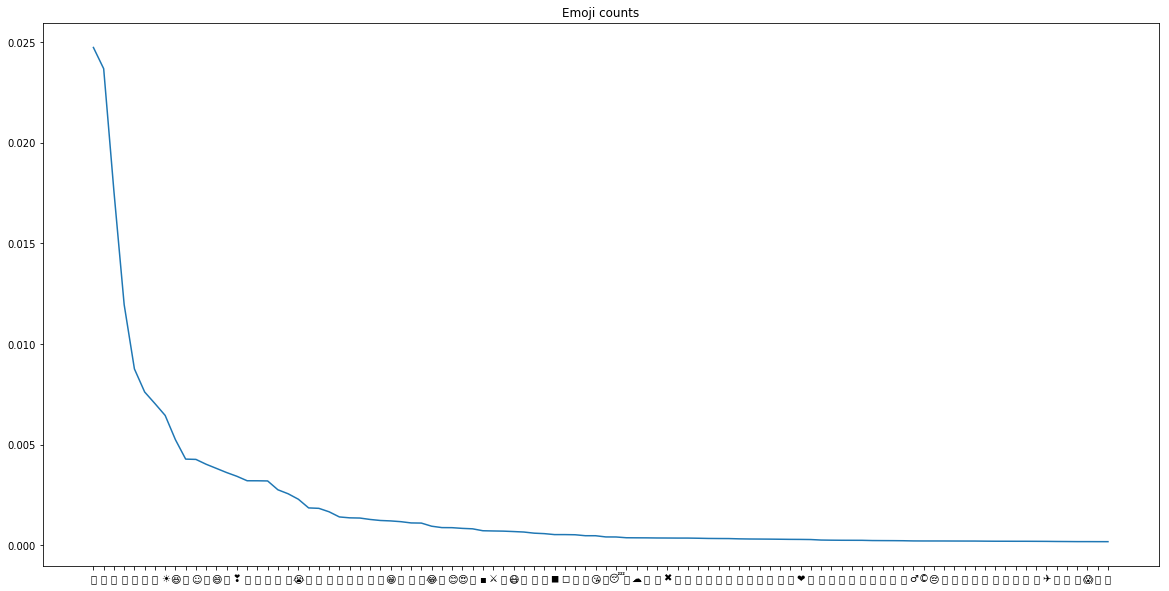

In [136]:
emojiis = [k[0] for k in normalized_rt_followers[:100]]
counts = [k[1] for k in normalized_rt_followers[:100]]

plt.figure(figsize = (20,10))
plt.plot(emojiis, counts)
plt.title('Emoji counts');

In [137]:
def followers_normalization(tweets):
    emoji_rt_dict = defaultdict(list)

    for tweet in tweets:
        this_dict = tweets[tweet]
        followers = int(re.sub(',', '', this_dict['followers']))
        for em, rt in zip(this_dict['emojis'], this_dict['retweets']):
            for e in em:
                emoji_rt_dict[e].append(float(followers))
                
    for em in emoji_rt_dict:
        emoji_rt_dict[em] = np.mean(emoji_rt_dict[em])
        
    sorted_emojis = sorted(emoji_rt_dict.items(), key=operator.itemgetter(1), reverse=True)

    return(sorted_emojis)

In [138]:
followers_normalization(tweets)

[('üç¨', 109578158.0),
 ('‚òë', 109578158.0),
 ('üê¥', 109578158.0),
 ('üóù', 109578158.0),
 ('‚Åâ', 109578158.0),
 ('üëÇ', 109578158.0),
 ('üçØ', 109578158.0),
 ('üé±', 88719231.0),
 ('üìì', 88719231.0),
 ('üíÖ', 86644729.83333333),
 ('üå¨', 83586445.5),
 ('üòë', 83381383.5),
 ('‚ò†', 78867988.0),
 ('üëº', 78867988.0),
 ('üêÜ', 73838661.0),
 ('üåÖ', 72986635.8),
 ('‚ùó', 70318628.5),
 ('üëÉ', 69439532.0),
 ('üå∏', 68739738.06422019),
 ('‚úè', 66963706.25),
 ('üè†', 66383979.0),
 ('üíÅ', 63349155.5),
 ('üé≠', 62794024.0),
 ('üåö', 62794024.0),
 ('üîñ', 62794024.0),
 ('üîà', 61839234.0),
 ('üï∂', 61252944.333333336),
 ('üëÅ', 60326996.28571428),
 ('‚òπ', 60238938.333333336),
 ('üê£', 58378259.666666664),
 ('üçé', 58170785.0),
 ('üçá', 58170785.0),
 ('üê†', 58170785.0),
 ('üê≠', 58170785.0),
 ('üëó', 58170785.0),
 ('üë°', 58170785.0),
 ('üëí', 58170785.0),
 ('‚õ∑', 58170785.0),
 ('üå©', 57594733.0),
 ('üöó', 57226806.0),
 ('üôÅ', 57184609.0),
 ('üö¢', 5

In [139]:
def rt_normalization(tweets):
    emoji_rt_dict = defaultdict(list)

    for tweet in tweets:
        this_dict = tweets[tweet]
        followers = int(re.sub(',', '', this_dict['followers']))
        for em, rt in zip(this_dict['emojis'], this_dict['retweets']):
            for e in em:
                emoji_rt_dict[e].append(float(rt))
                
    for em in emoji_rt_dict:
        emoji_rt_dict[em] = np.mean(emoji_rt_dict[em])
        
    sorted_emojis = sorted(emoji_rt_dict.items(), key=operator.itemgetter(1), reverse=True)

    return(sorted_emojis)

In [140]:
rt_normalization(tweets)

[('üç∫', 377582.0),
 ('üê≥', 361507.0),
 ('üíì', 269294.3888888889),
 ('üçª', 222417.0),
 ('üêØ', 183769.8),
 ('üåô', 133881.5),
 ('üíò', 116453.33333333333),
 ('‚òÄ', 101032.52777777778),
 ('üòÜ', 81173.84210526316),
 ('‚ò∫', 65540.3448275862),
 ('üêº', 65447.5),
 ('üíú', 62596.28571428572),
 ('üòÑ', 59441.32142857143),
 ('‚ù£', 56285.0),
 ('üå∫', 55591.28571428572),
 ('üçæ', 54137.083333333336),
 ('üê∂', 51127.833333333336),
 ('‚≠ê', 50590.80487804878),
 ('\U0001f929', 49286.05882352941),
 ('üíï', 40661.81481481482),
 ('üó°', 38556.0),
 ('üò≠', 35833.49295774648),
 ('üçÄ', 28826.14285714286),
 ('ü•ö', 28670.0),
 ('üò∑', 27722.666666666668),
 ('üññ', 27568.0),
 ('üò¨', 22624.083333333332),
 ('\U0001f9e1', 21659.764705882353),
 ('üíó', 21023.58823529412),
 ('üòÅ', 20801.875),
 ('üì∏', 20250.05),
 ('‚ñ™', 20100.0),
 ('üëç', 19982.36923076923),
 ('üíö', 19950.684210526317),
 ('üíû', 17376.363636363636),
 ('üò¥', 17272.625),
 ('ü§ò', 16033.5),
 ('‚òé', 15669.

# Predict sentiment of emojis

In [119]:
emoji_sentiment = pd.DataFrame(columns = ['emoji', 'sentiment'])


In [120]:
emoji_sentiment = pd.DataFrame(columns = ['emoji', 'sentiment'])
for i,tweet in enumerate(tweets):

    this_list = tweets[tweet]
    for em, sent in zip(this_list['emojis'], this_list['score']):
        
        if len(em)>0:
            for e in em:
                emoji_sentiment = pd.concat([emoji_sentiment, pd.DataFrame({'emoji':e, 'sentiment':sent}, index = [0,1])])

In [121]:
emoji_sentiment

emoji  sentiment
0      üëÅ     0.0000
1      üëÅ     0.0000
0      ‚ù§     0.0000
1      ‚ù§     0.0000
0      ‚ùó     0.0000
1      ‚ùó     0.0000
0      üéÇ     0.0000
1      üéÇ     0.0000
0      üéà     0.0000
1      üéà     0.0000
0      ü§ù     0.3400
1      ü§ù     0.3400
0      üåé     0.3400
1      üåé     0.3400
0      üí™     0.3400
1      üí™     0.3400
0      üåç     0.3400
1      üåç     0.3400
0      üôå     0.3400
1      üôå     0.3400
0      üåè     0.3400
1      üåè     0.3400
0      ‚ù§     0.3400
1      ‚ù§     0.3400
0      üëµ     0.3400
1      üëµ     0.3400
0      üåà     0.8360
1      üåà     0.8360
0      ‚ù§     0.8360
1      ‚ù§     0.8360
..   ...        ...
0      üëå     0.0000
1      üëå     0.0000
0      üëç     0.0000
1      üëç     0.0000
0      üòâ     0.0000
1      üòâ     0.0000
0      üëå     0.0000
1      üëå     0.0000
0      üî¥     0.0000
1      üî¥     0.0000
0      üòç    -0.0601
1      üòç    -0.0601
0      üëè     0.0000
1      üëè     0.0000
0      üëè     0.0000
1      üëè     0.0000
0      üéÖ     0.0000
1      üéÖ     0.0000
0      üëè     0.0000
1      üëè     0.0000
0      üòâ     0.7184
1      üòâ     0.7184
0      üôå     0.0000
1      üôå     0.0000
0      ‚û°     0.0000
1      ‚û°     0.0000
0      ü§©     0.0000
1      ü§©     0.0000
0      üé∂     0.0000
1      üé∂     0.0000

[23644 rows x 2 columns]

## Do regression on sentiment

In [122]:
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [123]:
def linear_regression(df):
    X_train, X_test = train_test_split(df)
    
    y_train = X_train['sentiment']
    y_test = X_test['sentiment']

    # Create linear regression object
    regr = LinearRegression()

    X_train = X_train.drop(['sentiment'], axis = 1)
    X_test = X_test.drop(['sentiment'], axis = 1)
    le = LabelEncoder()
    
    le_fit = le.fit(emoji_sentiment['emoji'])
    X_train = le_fit.transform(X_train).reshape(-1, 1)
    X_test = le_fit.transform(X_test).reshape(-1, 1)
    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    preds = regr.predict(X_test)
    return(mean_squared_error(y_test, preds))

In [124]:
print(linear_regression(emoji_sentiment))

0.14114435400018907


/Users/saramahar/anaconda/envs/nlp/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [127]:
def random_forest(df):
    X_train, X_test = train_test_split(df)
    
    y_train = X_train['sentiment']
    y_test = X_test['sentiment']

    # Create linear regression object
    regr = RandomForestRegressor()

    X_train = X_train.drop(['sentiment'], axis = 1)
    X_test = X_test.drop(['sentiment'], axis = 1)
    le = LabelEncoder()
    
    le_fit = le.fit(emoji_sentiment['emoji'])
    X_train = le_fit.transform(X_train).reshape(-1, 1)
    X_test = le_fit.transform(X_test).reshape(-1, 1)
    # Train the model using the training sets
    regr.fit(X_train, y_train)

    # Make predictions using the testing set
    preds = regr.predict(X_test)
    return(mean_squared_error(y_test, preds))

In [128]:
print(random_forest(emoji_sentiment))

0.12191622359443988


/Users/saramahar/anaconda/envs/nlp/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
